# Módulo 00

## CRISP-DM (Cross-Industry Process - Data Science)

- Método cíclico de desenvolvimento (velocidade de entrega, mapeamento de problemas, etc)

<b> Etapas do ciclo
    
<ul>
    <li>Questão de Négocio</li>
    <li>Entendimento do Negócio (não sair fazendo)</li>
    <li>Coleta de Dados</li>
    <li>Limpeza dos Dados</li>
    <li>Exploração dos Dados</li>
    <li>Modelagem dos Dados</li>
    <li>Algoritmos de ML</li>
    <li>Avaliação do Algoritmo -> <b>(se tudo está certo)</b> -> Modelo em Produção</li>    
</ul> 
    

## Primeiros passos para resolver o problema

- Quantidade de dados: tenho os recursos adequados para trabalhar? Preciso de servidores, clusters, spark, hadoop, etc?

- Tipo de variáveis: quais os tipos de variáveis?

- Quantidade de dados faltantes: qual o volume de NA; qual a razão de faltar dados;

- Resumo Geral dos Dados: Estatística Descritiva.

## 0.0 Imports 

In [109]:
import pandas as pd
import numpy as np

import pickle
import inflection
from tabulate import tabulate
import random

import math
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from boruta import BorutaPy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.core.display import HTML
from IPython.display import Image

In [2]:
from platform import python_version

print(python_version())

3.9.12


### 0.1 Helper Functions 

In [110]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    
    
def cramer_v(x,y):
    
    # Contingency Table
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape # take number of columns and rows
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corrected = max(0, chi2 - (k-1)*(r-1)/(n-1))
    k_corrected = k - (k-1)**2/(n-1)
    r_corrected = r - (r-1)**2/(n-1)
    
    # Cramer's V
    v = np.sqrt( (chi2_corrected/n) / (min(k_corrected-1,r_corrected-1)) )
    
    return v

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


### 0.2 Loading Data 

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merging data
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

### 0.3 Usando o colab p/ rodar o jupyter (testar se uso da GPU ajuda a não travar)

In [5]:
# jupyter notebook \
# --NotebookApp.allow_origin='https://colab.research.google.com' \
#  --port=8888 \
# --NotebookApp.port_retries=0

# Módulo 01 - Entendendo o problema de negócio

In [6]:
# creating a copy help us avoid change data in the original dataset
df1 = df_raw.copy()

## 1.0 Data Description

### 1.1 Rename Columns 

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 
            'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# finishing rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


### 1.3 Data Types

In [9]:
# transforming date from object to datetime
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA 

- We can discard de null data (but if number of NA is big, we will influence the results)
- We can use ML algorithms
- We can use the business-understanding

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA 

### 1.6 Descriptive Statistical 

In [12]:
# column: competition_distance -> using a huge distance if the distance is bigger than the maximum distance
max_distance = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) 
                                                                else x)

# column: competition_open_since_month -> assumption: using the month of last sale store
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                else x['competition_open_since_month'], axis=1)

# column: competition_open_since_year -> assumption: using the year of last sale store
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                else x['competition_open_since_year'], axis=1)

# column: promo_2_since_week -> replacing the NA by week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                else x['promo2_since_week'], axis=1)

# column: promo_2_since_week -> replacing the NA by year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                else x['promo2_since_year'], axis=1)

# column: promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 
             7:'Jun', 8:'Jul', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

# if the promo interval doesn't exist, we will complete the column with 0
df1['promo_interval'].fillna(0, inplace=True)

# changing the NUMBER MONTH by NAME MONTH
df1['month_map'] = df1['date'].dt.month.map(month_map)

# if month date is inside promo interval, we will complete the column with 1
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                             if x['month_map'] in x['promo_interval'].split(',') 
                                                             else 0, axis=1)

# convert from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [13]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\User\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### 1.6.1 Numerical Attributes 

In [14]:
# inclunding numerical data
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [15]:
# Central Tendency (mean, median) 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion (std, min, max, range, skew, kurtosis) 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenating data
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.163637,0.0,0.369946,1.818447,1.306754


#### 1.6.2 Categorical Attributes

In [16]:
# excluding numerical data
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       11
dtype: int64

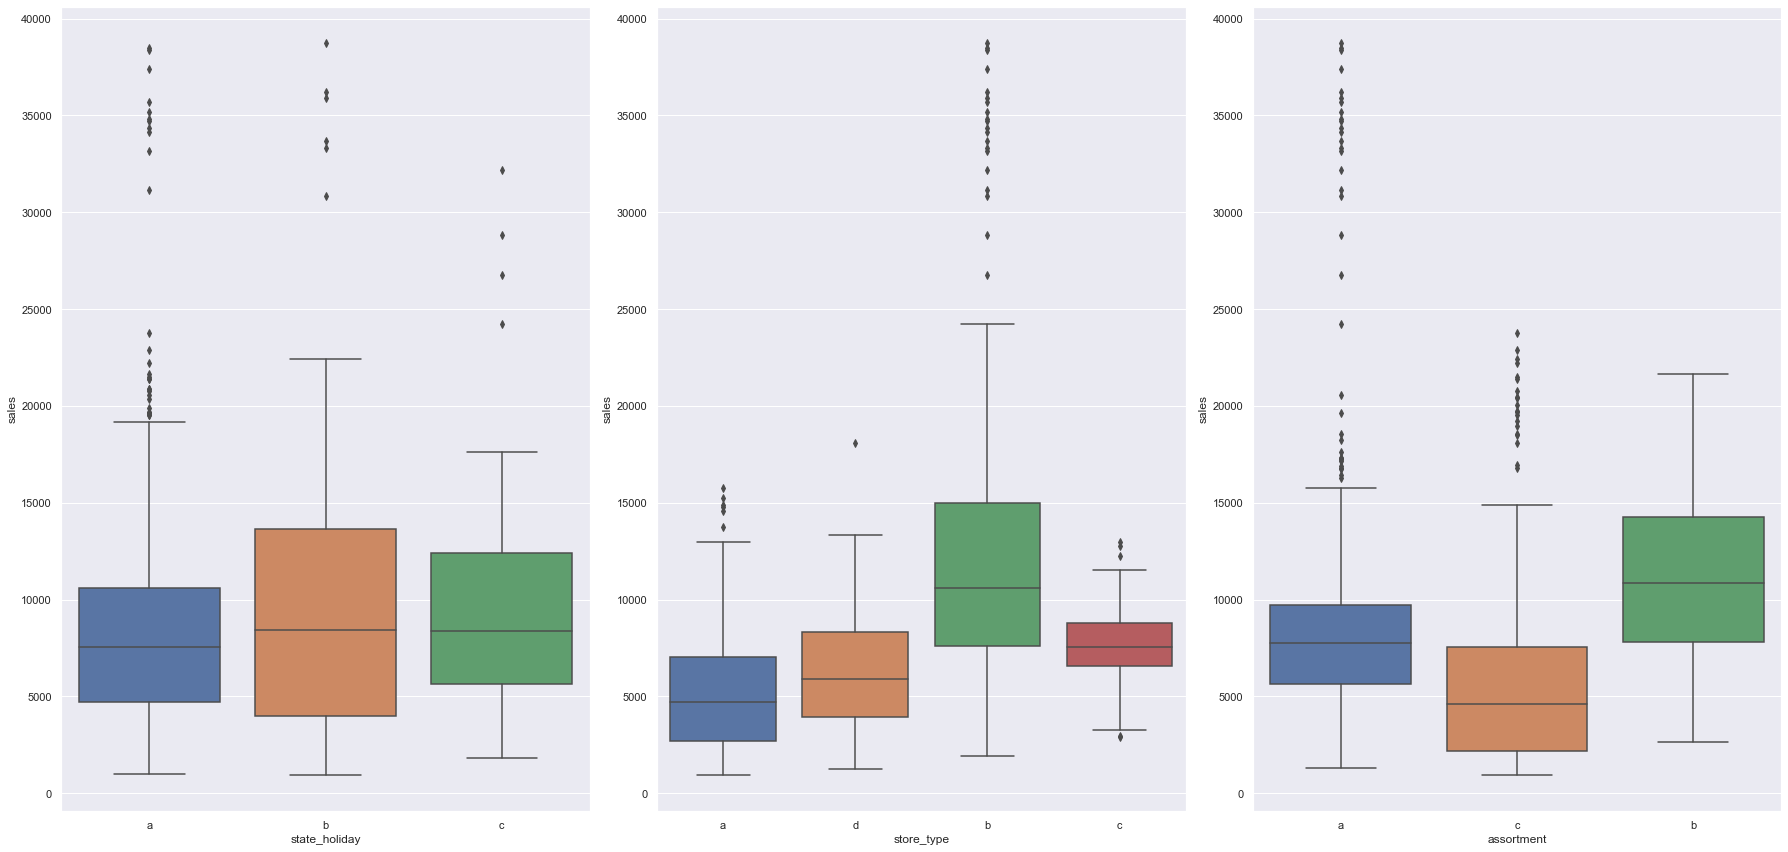

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.tight_layout()

# Módulo 02 - Análise Descritiva dos Dados

## 2.0 Criação de Hipóteses 

<p style="font-size:24px">Mapa Mental de Hipóteses</p>

1. Fenômenos: qual fenômeno estou modelando?

2. Agentes: quem são os agentes que atuam sobre o fenômeno de interesse?

3. Atributos do Agentes: qual a descrição dos agentes?

4. Lista de hipóteses: hipóteses para validar com os dados.

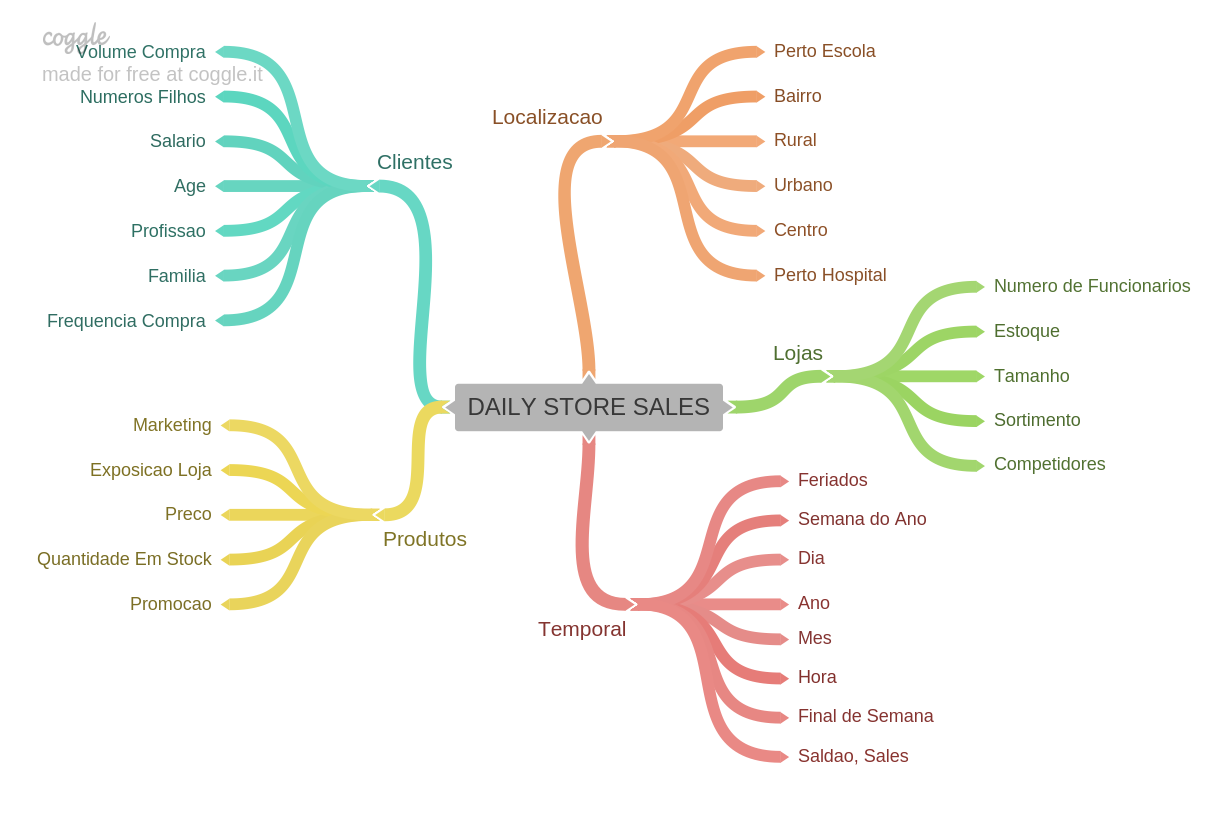

In [19]:
Image('img/mindmap.png')

## 2.1 Lista Final de Hipóteses 

### 2.1.1 Hipótese de loja 

1. Lojas com maior quadro de funcionários devem vender mais.
<br><br>
2. Lojas com maior estoque deveriam vender mais.
<br><br>
3. Lojas com maior porte deveriam vender mais.
<br><br>
4. Lojas com maior sortimento deveriam vender mais.

### 2.1.2 Hipótese de produto

1. Lojas que investem mais em marketing deveriam vender mais.
<br><br>
2. Lojas que expõem mais os produtos nas vitrines deveriam vender mais.
<br><br>
3. Lojas que tem preços menores nos produtos deveriam vender mais.
<br><br>
4. Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

### 2.1.3 Hipóteses de tempo 

1. Lojas deveriam vender mais ao longo dos anos.
<br><br>
2. Lojas deveriam vender mais no segundo semestre do ano.
<br><br>
3. Lojas deveriam vender mais depois do dia 10 de cada mês.
<br><br>
4. Lojas deveriam vender menos aos finais de semana.
<br><br>
5. Lojas deveriam vender menos durante os feriados escolares.

### 2.1.4 Hipóteses Finais

<ol style="font-size:16px">
    <li>Lojas com maior sortimento deveriam vender mais.</li>
    <li>Lojas com competidores mais próximos deveriam vender mais.</li>
    <li>Lojas com competidores à mais tempo deveriam vender mais.</li>
    <li>Lojas com promoções ativas por mais tempo deveriam vender mais.</li>
    <li>Lojas com mais dias de promoção deveriam vender mais.</li>
    <li>Lojas com mais promoções consecutivas deveriam vender mais.</li>
    <li>Lojas abertas durante o feriado de Natal deveriam vender mais.</li>
    <li>Lojas deveriam vender mais ao longo dos anos.</li>
    <li>Lojas deveriam vender mais no segundo semestre do ano.</li>
    <li>Lojas deveriam vender mais depois do dia 10 de cada mês.</li>
    <li>Lojas deveriam vender menos aos finais de semana.</li>
    <li>Lojas deveriam vender menos durante os feriados escolares.</li>
</ol>

# Módulo 03 - Feature Engineering

## 3.1 Feature Engineering 

In [20]:
df2 = df1.copy()

In [21]:
df2['date'] = df2['date'].values.astype('datetime64[D]')

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') # return the year and the week of the date

In [22]:
# competition since
# criaremos uma coluna para nos dizer a quantos meses existe competição entre as lojas
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1) # use day equal 1 to consider all month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
# criaremos uma coluna para nos dizer a quantos meses existe promoção na loja
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)) # create start day of second promo
# https://www.programiz.com/python-programming/datetime/strptime 
# %Y:Year with century as a decimal number; 
# %W:Week number of the year (Monday as the first day of the week); 
# %w: Weekday as a decimal number.
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int) # give us the number of consecutive promo weeks

In [23]:
# assortment
# a = basic; b = extra; c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else ('extra' if x == 'b' else 'extended'))

# state holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else('easter_holiday' if x == 'b' else ('christmas_holiday' if x == 'c' else 'regular_day')))

## 3.2 Filtragem de Variáveis 

<p style="font-size:16px"><b> Filtragem de variáveis </b> está conectada diretamente às restrições de acordo com o negócio.</p>

<p style="font-size:16px"><b> Seleção de variáveis </b> está conectada diretamente às variáveis mais relevantes ao modelo.</p>

In [24]:
df3 = df2.copy()

### 3.2.1 Filtragem das linhas 

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jun,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jun,0,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jun,0,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jun,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jun,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


Coluna <b>customers</b>: é uma coluna que eu não tenho no momento da predição. Seria necessário um projeto para predizer quantos 'customers' haveriam nas próximas 6 semanas (intervalo da predição do nosso projeto), portanto, não podemos usá-la no nosso projeto desta forma (restrição de negócio);

Coluna <b>open</b>: excluir linhas onde as lojas estavam fechadas (após a filtragem, podemos deletar a coluna, pois só terá valores igual a 1);

Coluna <b>sales</b>: excluir linhas onde as 'sales' seja menores ou iguais a zero;

Coluna <b>promo_interval</b> e Coluna <b>month_map</b>: são colunas auxiliares, podem ser deletadas.

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2.2 Seleção das colunas 

In [27]:
drop_columns = ['customers', 'open', 'promo_interval', 'month_map']

df3.drop(drop_columns, axis=1, inplace=True)

# Módulo 04 - Exploratory Data Analysis

<p style="font-size:16px"><b>Perguntas da EDA:</b></p>

<p style="font-size:16px">Como as variáveis impactam o fenômeno?</p>
<p style="font-size:16px">Qual a força desse impacto?</p>

____________________________________________________________________________

<p style="font-size:16px"><b>Objetivos da EDA:</b></p>

<ul>
    <li style="font-size:16px">Ganhar experiência de negócio
    <li style="font-size:16px">Validar hipóteses de negócio -> insights</li>
    <li style="font-size:16px">Perceber variáveis importantes para o modelo</li>
    </ul>
    

<p style="font-size:16px"><b>Tipos de análise:</b></p>

Análise univariada: mínimo, máximo, distribuição, range;

Análise bivariada: como a variável impacta na resposta (correlação, validação de hipóteses, ...)

Análise multivariada: como as variáveis se relacionam?

## 4.0 Análise Exploratória dos Dados 

In [28]:
df4 = df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Variável Resposta

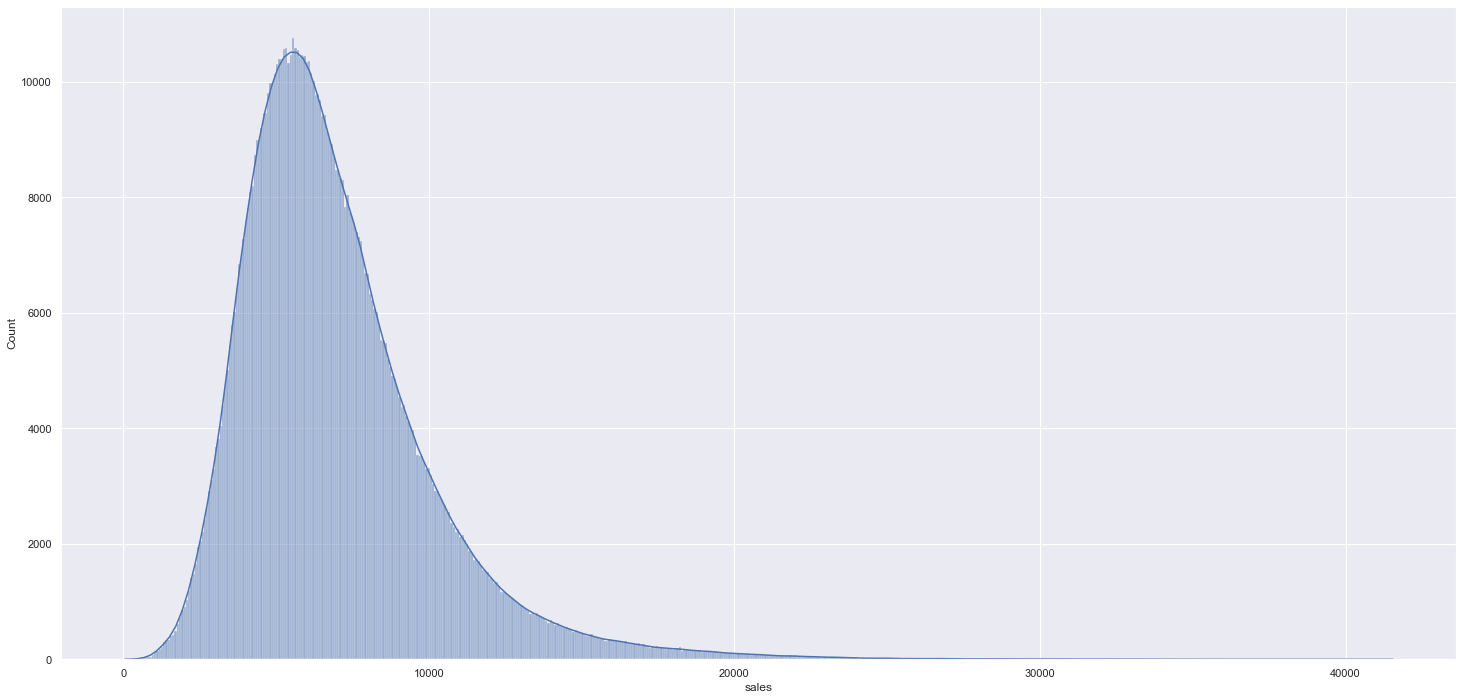

In [29]:
sns.histplot(df4['sales'], kde=True);

### 4.1.2 Variáveis Numéricas 

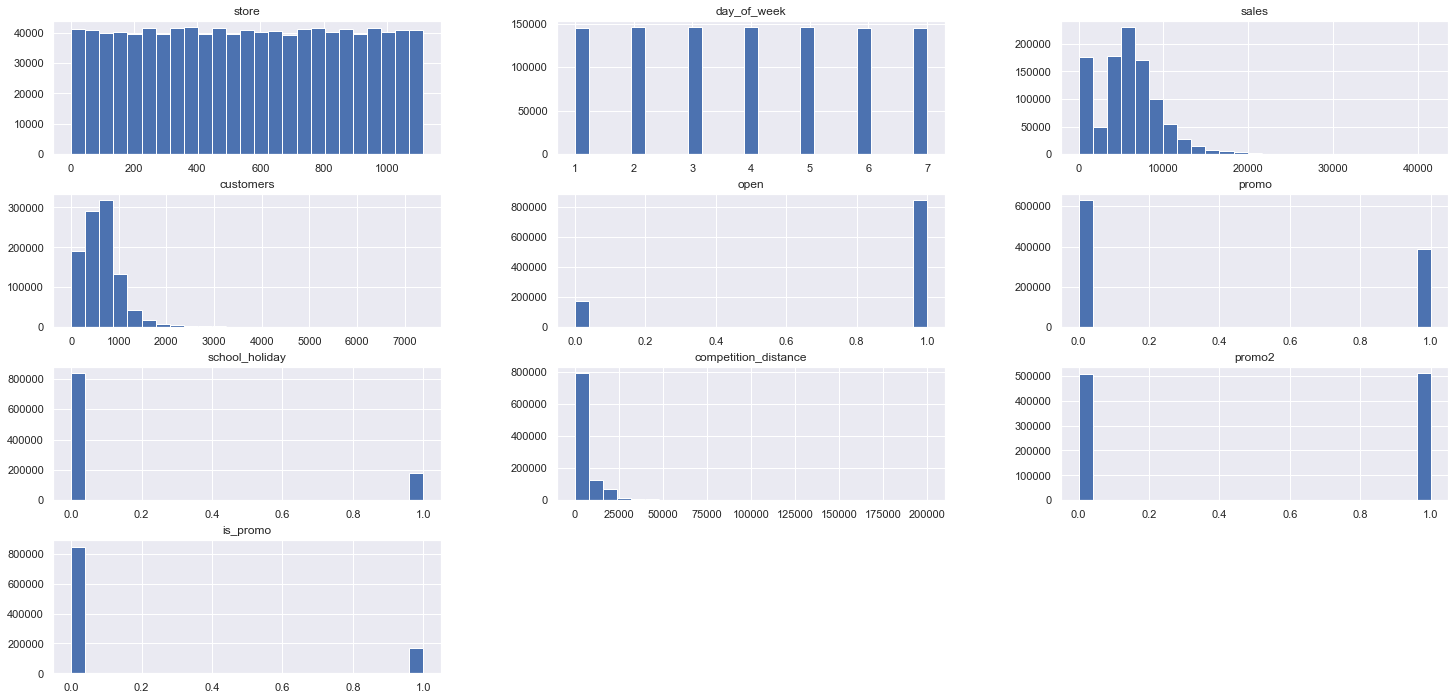

In [30]:
num_attributes.hist(bins=25);

### 4.1.3 Variáveis Categóricas 

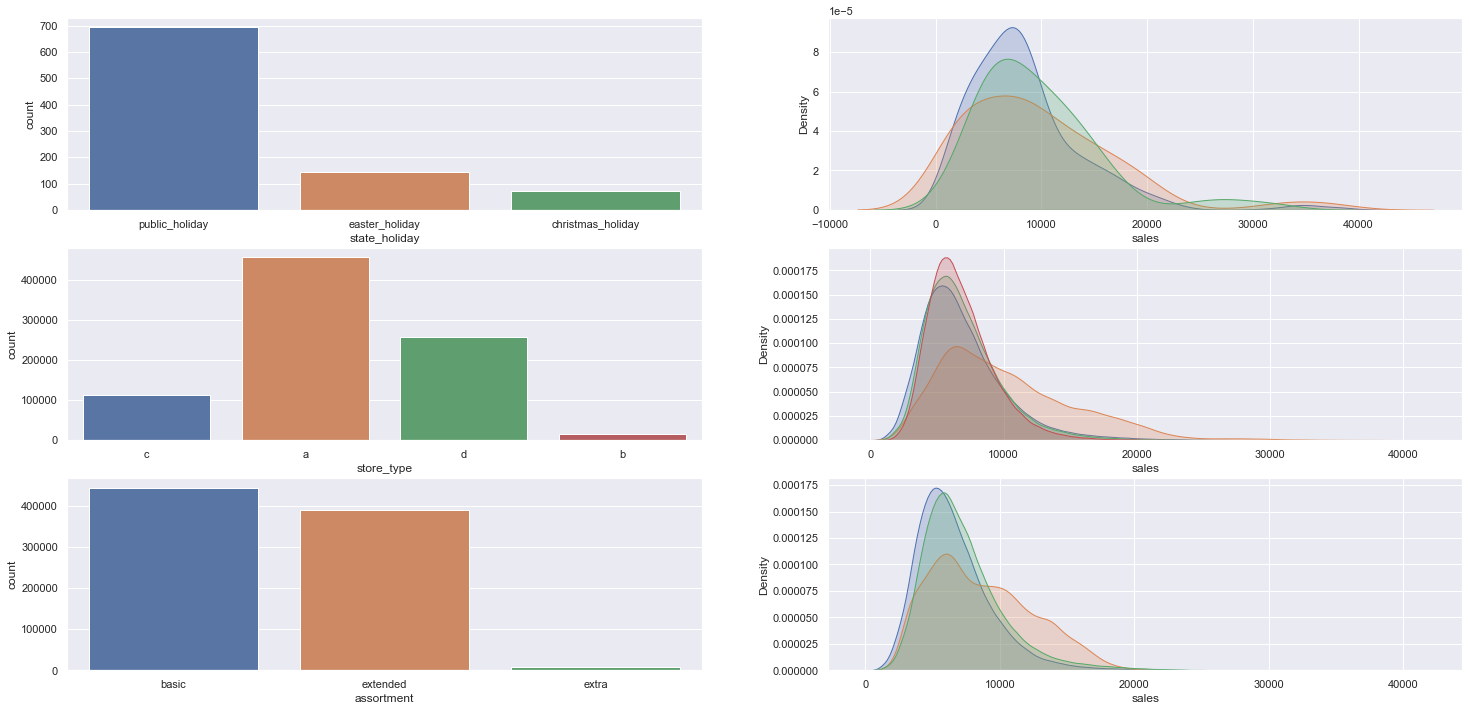

In [31]:
# state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']['state_holiday']
sns.countplot(x=a);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label='christmas_holiday', shade=True);

#store type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

#assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);

## 4.2 Análise Bivariada 

### 4.2.1 -> H1: Lojas com maior sortimento deveriam vender mais. 

FALSA -> Lojas com <span style="font-size:16px"><b>maior sortimento</b></span> vendem <span style="font-size:16px"><b>menos</b></span>.

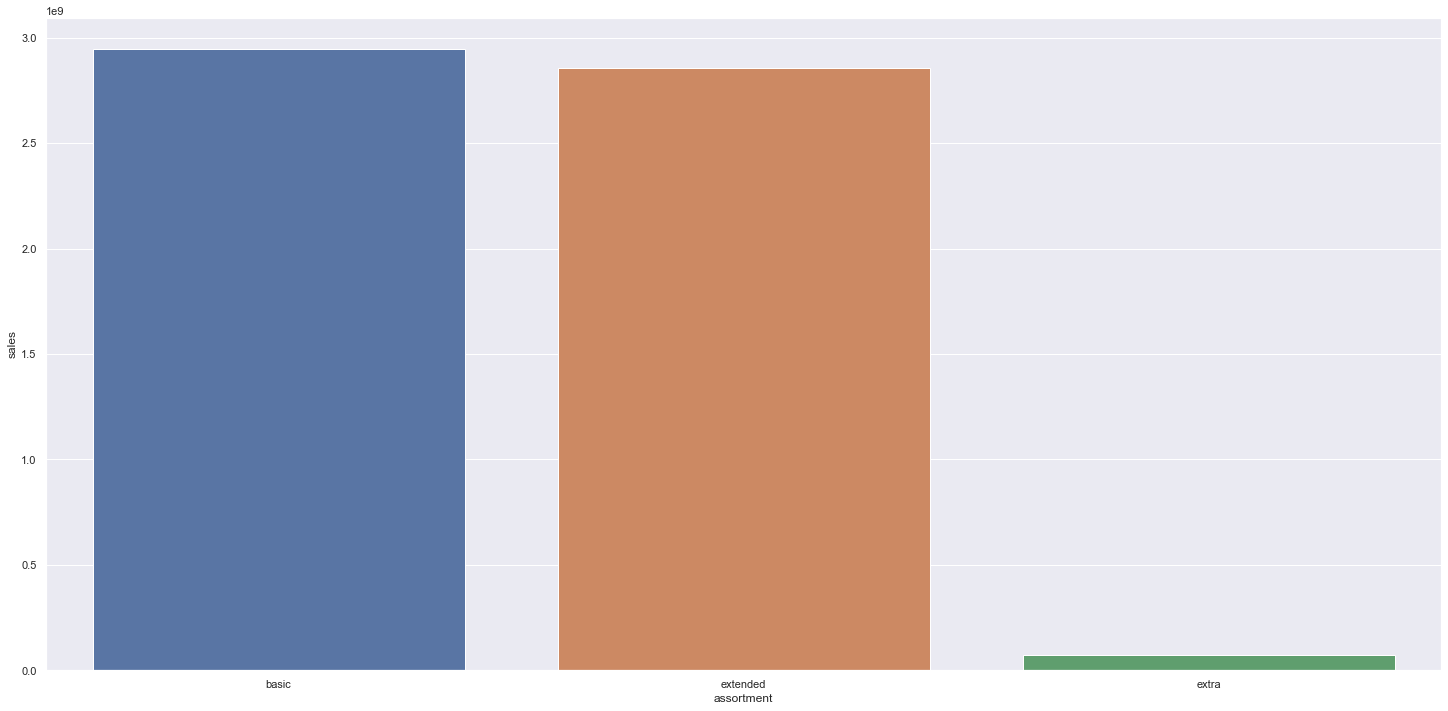

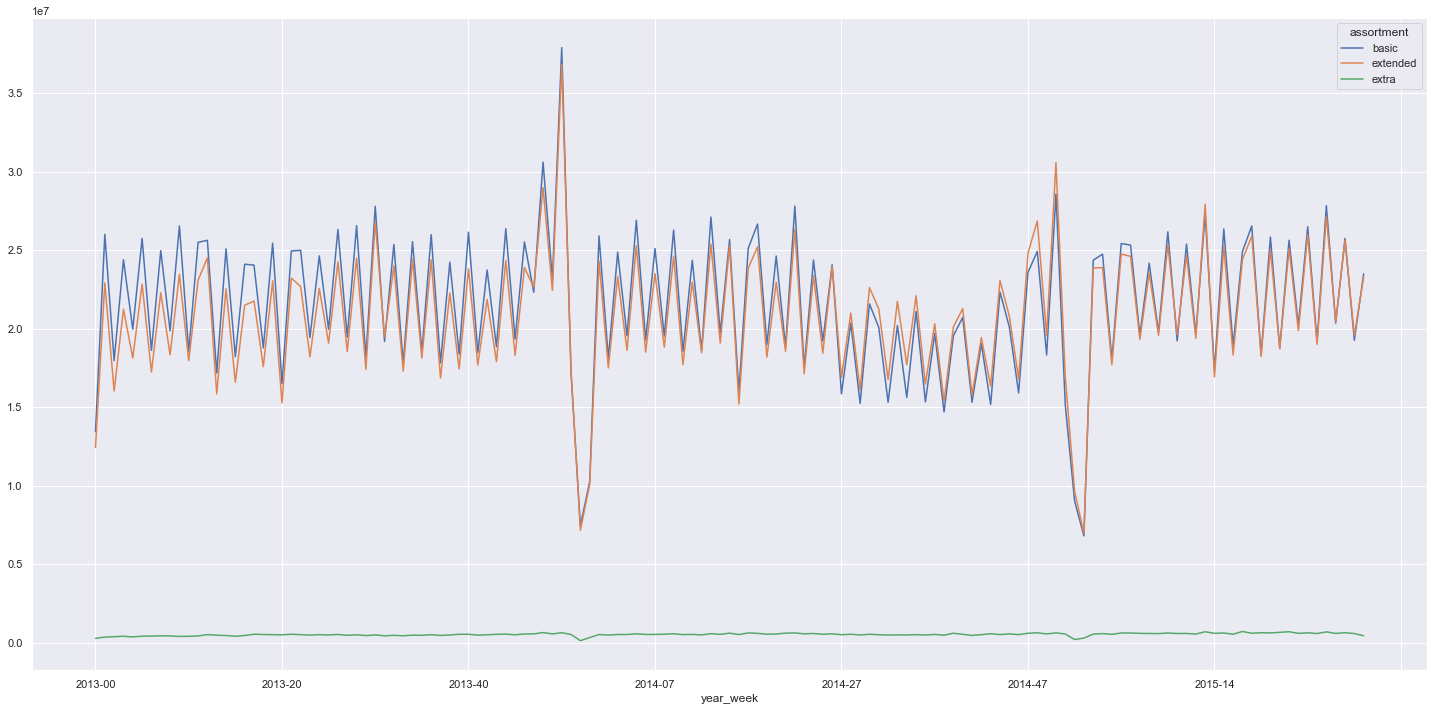

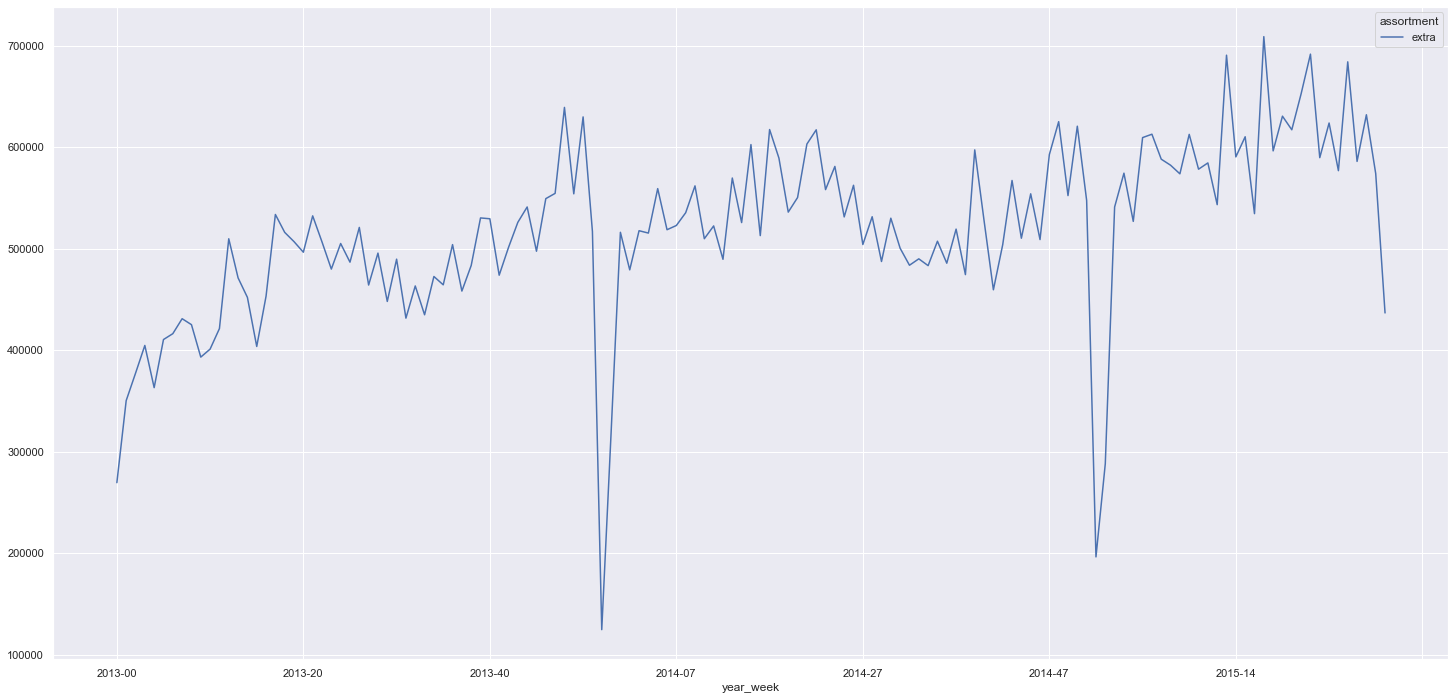

In [32]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
# pivotaremos aux2 para facilitar a visualização dos dados
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### 4.2.2 -> H2: Lojas com competidores mais próximos deveriam vender menos. 
FALSA -> Lojas com <span style="font-size:16px"><b>competidores mais próximos</b></span> vendem <span style="font-size:16px"><b>mais</b></span>.

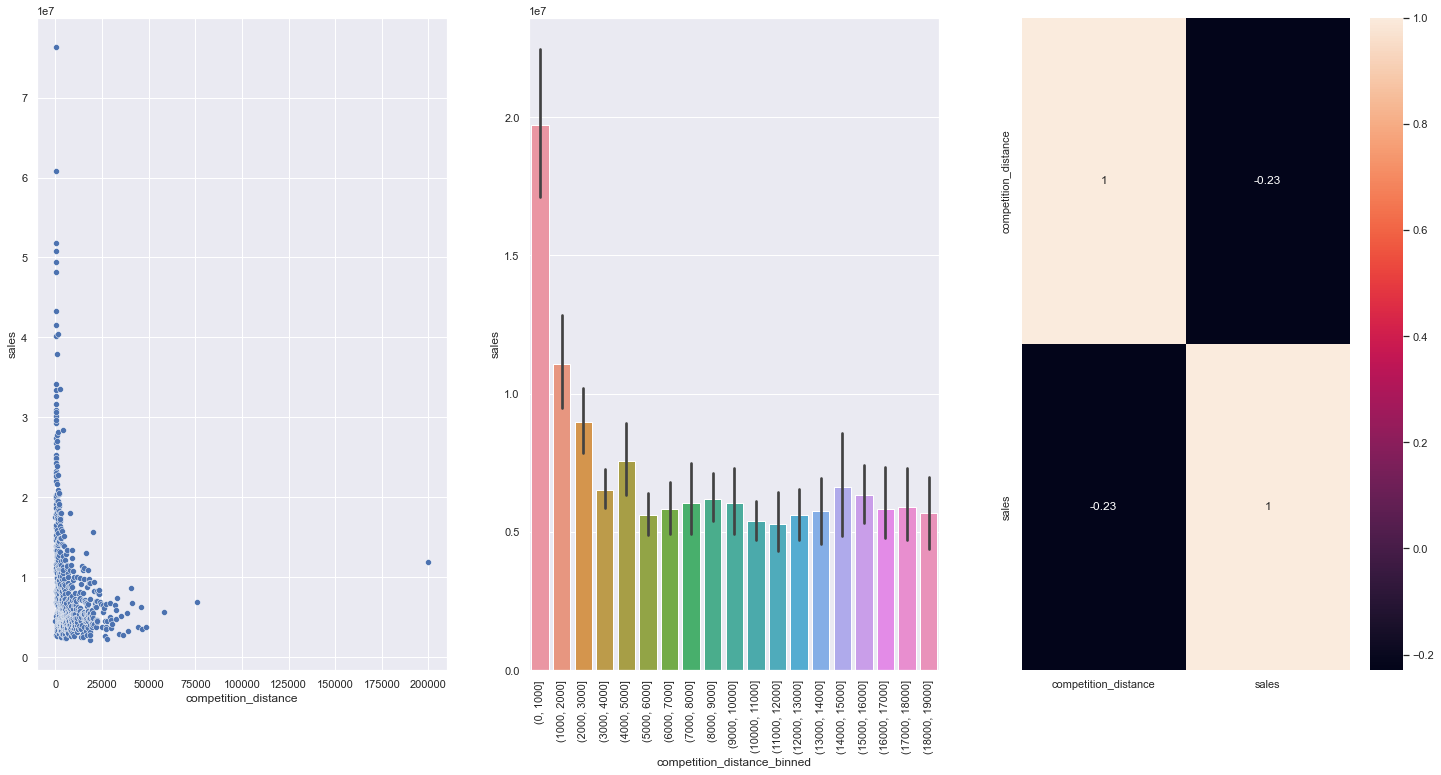

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
# sns.barplot(x='competition_distance', y='sales', data=aux1); -> visualização fica muito ruim
# criaremos bins para facilitar a visualização
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_binned', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.3 -> H3: Lojas com competidores à mais tempo deveriam vender mais.
FALSA -> Lojas com <span style="font-size:16px"><b>competidores a mais tempo</b></span> vendem <span style="font-size:16px"><b>menos</b></span>.

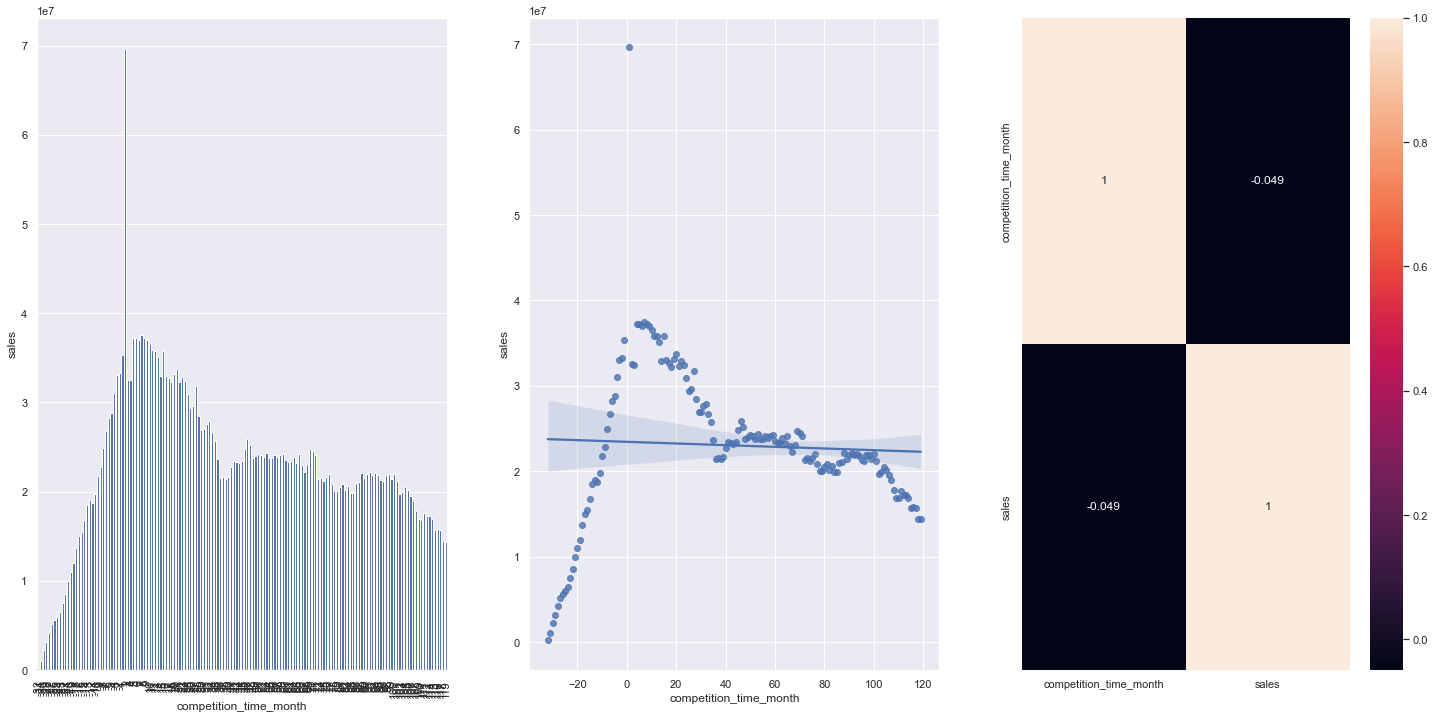

In [34]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# para melhorar a visualização, vamos criar uma filtragem
# manteremos somentes os primeiros 120 meses de competição
# e removeremos os competidores com tempo de competição igual a zero (abriu no mesmo mês da venda)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2, color='b');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2, color='b');

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### 4.2.4 -> Lojas com promoções ativas por mais tempo deveriam vender mais. 
FALSA -> Lojas com <span style="font-size:16px"><b>promoções ativas por mais tempo</b></span> vendem <span style="font-size:16px"><b>menos, depois de um certo período de promoção</b></span>.

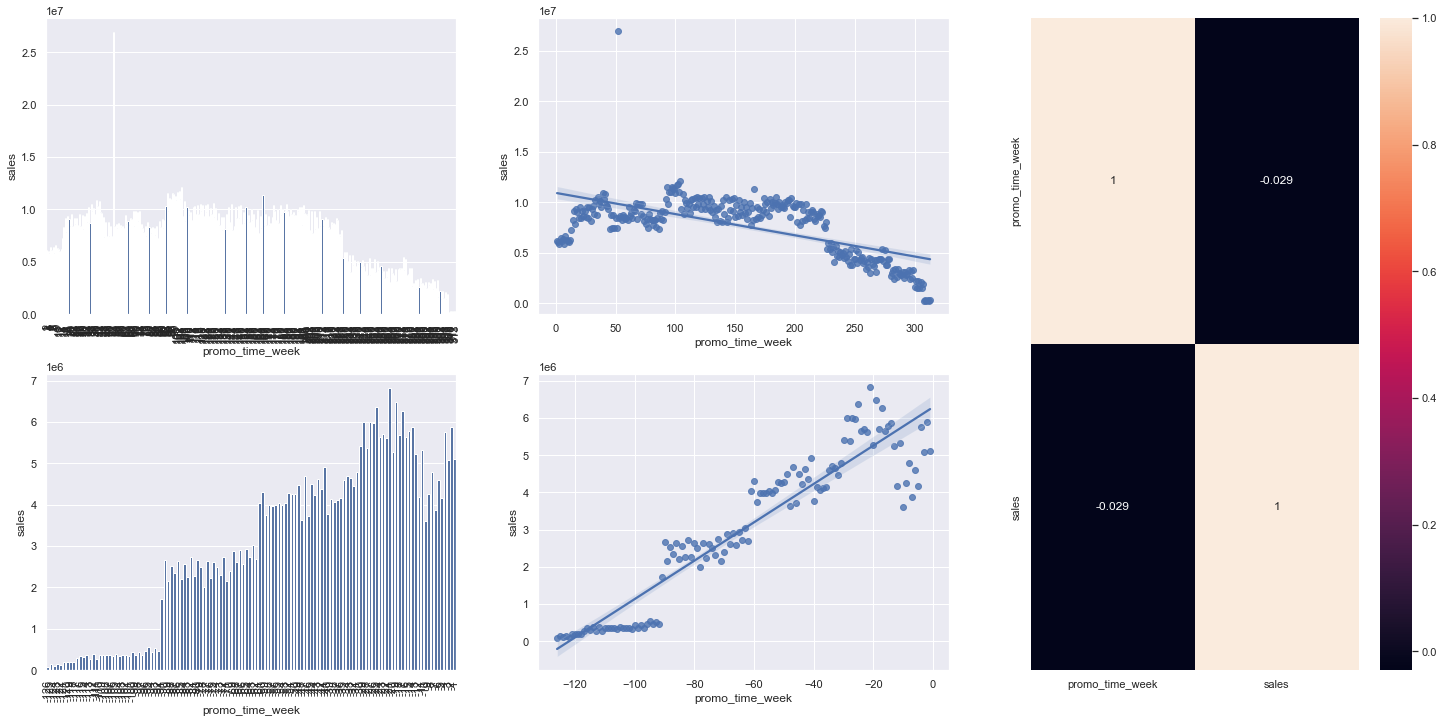

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2, color='b');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3, color='b');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.5 -> Lojas com mais dias  de promoção deveriam vender mais. 
- SERÁ VALIDADA NO PRÓXIMO CICLO

### 4.2.6 -> Lojas com mais promoçẽs consecutivas deveriam vender mais.
FALSA -> Lojas com <span style="font-size:16px"><b>promoções</b></span> vendem <span style="font-size:16px"><b>menos</b></span>.

In [36]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


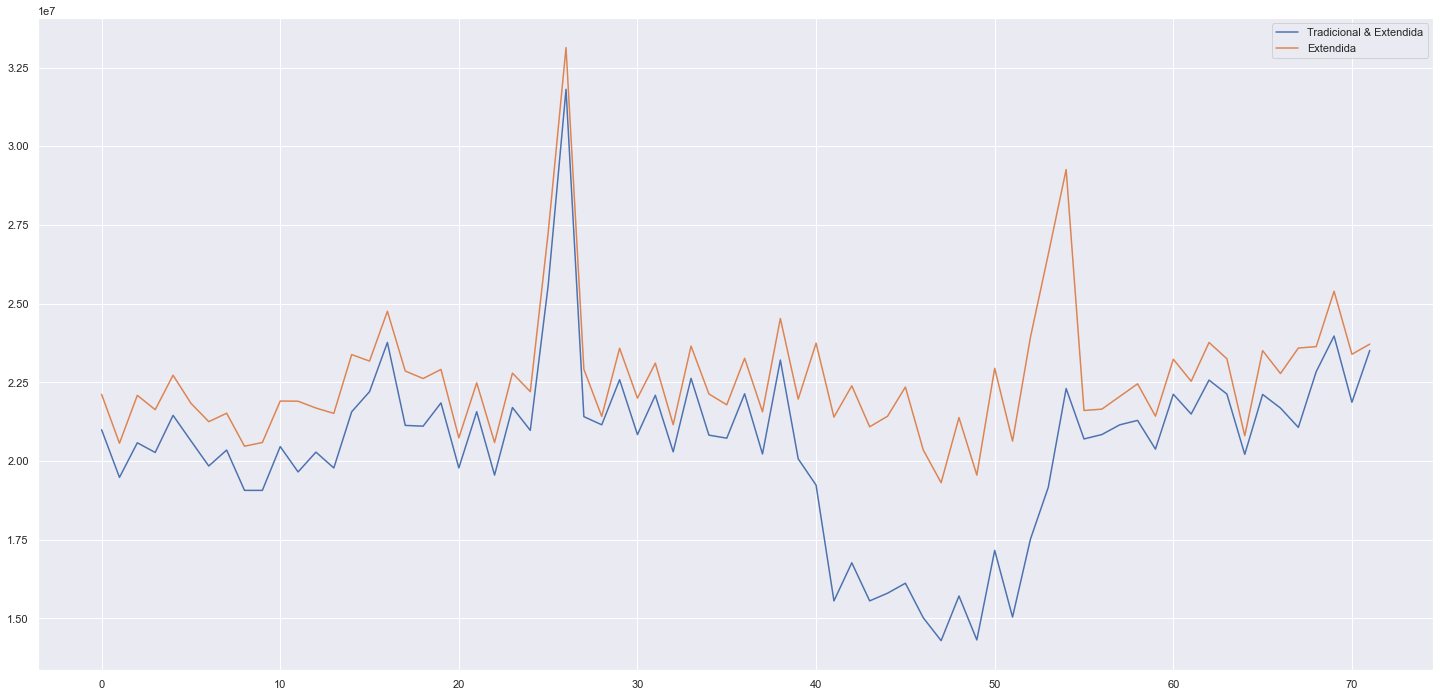

In [37]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### 4.2.7 -> Lojas abertas durante o feriado de Natal deveriam vender mais
FALSA -> Lojas <span style="font-size:16px"><b>vendem menos</b></span> durante o <span style="font-size:16px"><b>feriado de Natal</b></span>.

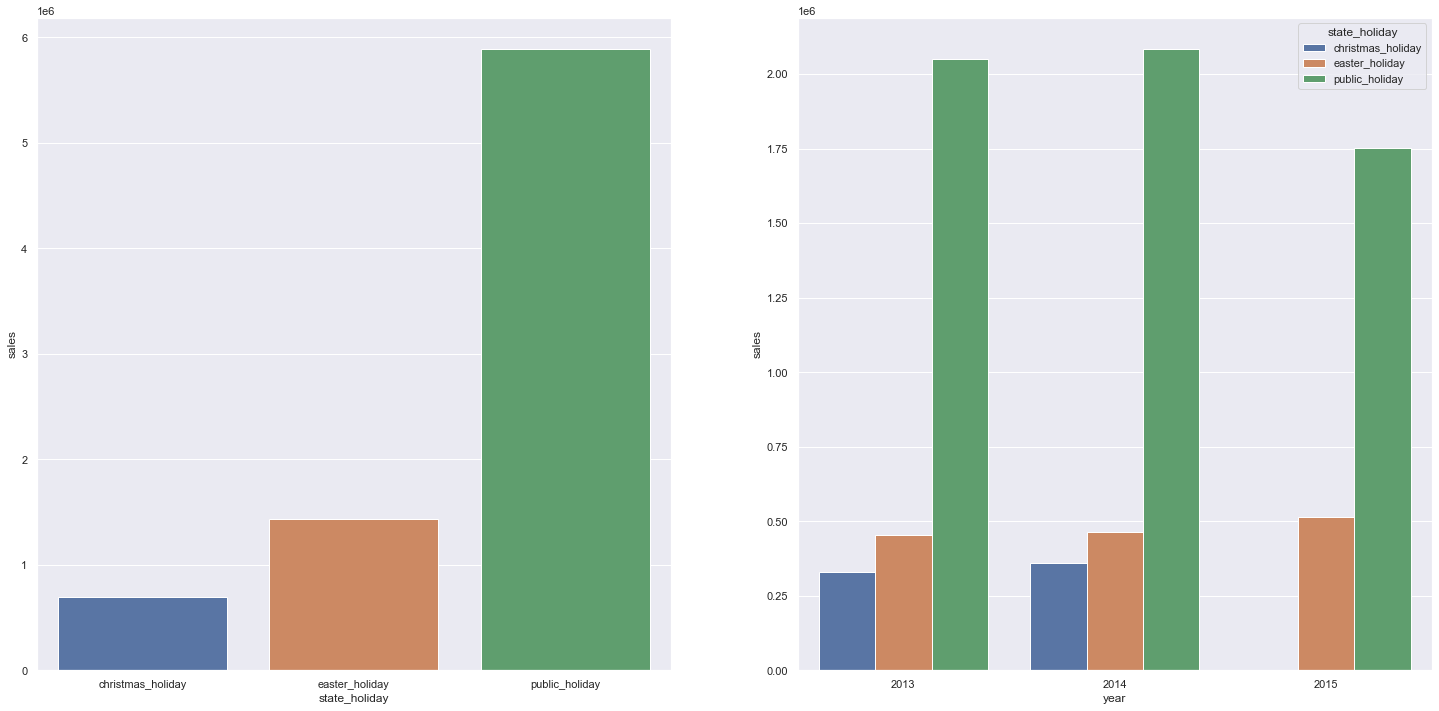

In [38]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

# vendas por ano
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### 4.2.8 -> Lojas deveriam vender mais ao longo dos anos
FALSA -> Lojas <span style="font-size:16px"><b>vendem menos</b> </span><span style="font-size:16px"><b>ao longo dos anos</b></span>.

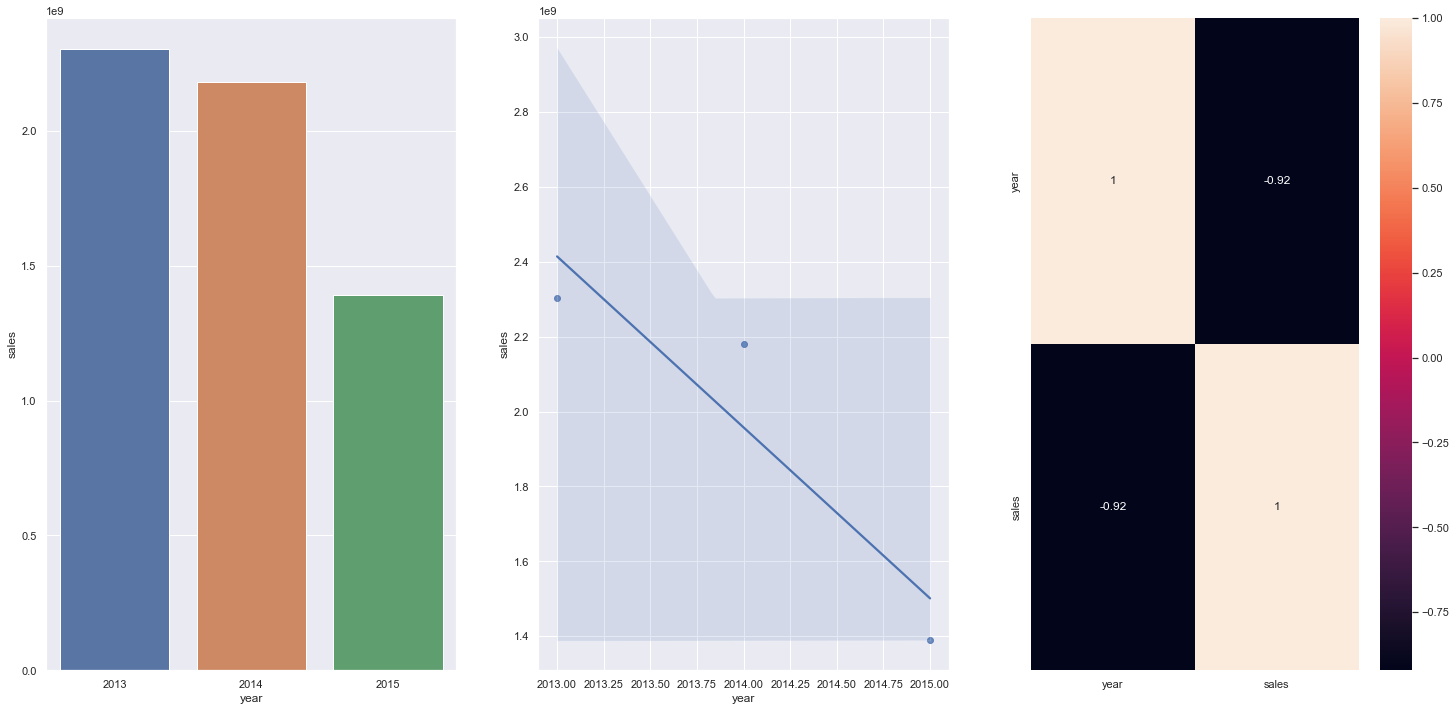

In [39]:
aux1 = df4[['sales','year']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.9 -> Lojas deveriam vender mais no segundo semestre do ano
FALSA -> Lojas <span style="font-size:16px"><b>vendem menos</b> </span><span style="font-size:16px"><b>no segundo semestre</b></span>.

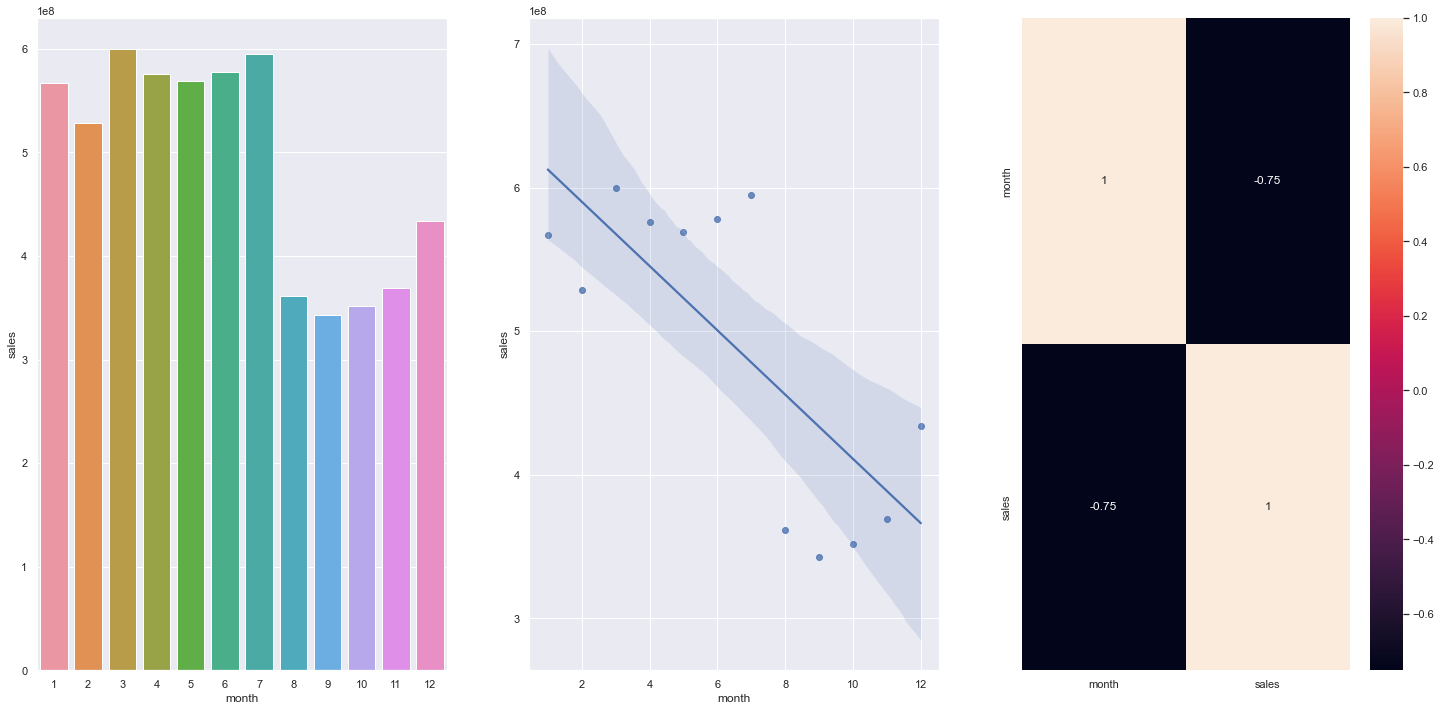

In [40]:
aux1 = df4[['sales','month']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.10 -> Lojas deveriam vender mais depois do dia 10 de cada mês
VERDADEIRA -> Lojas <span style="font-size:16px"><b>vendem mais</b> </span><span style="font-size:16px"><b>depois do dia 10 de cada mês</b></span>.

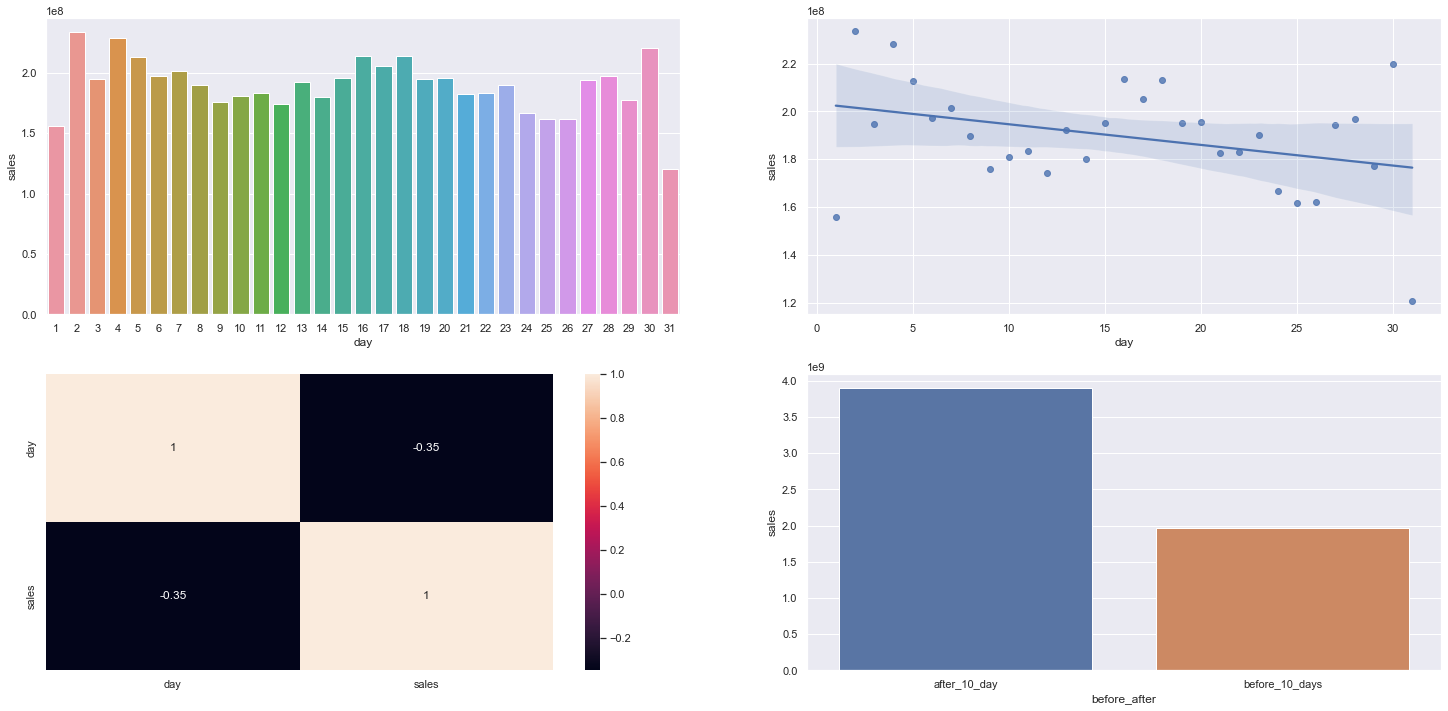

In [41]:
aux1 = df4[['sales','day']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales',data=aux2);

In [42]:
aux2['proportion'] = aux2.apply(lambda x: x['sales']/20 if x['before_after'] == 'after_10_day' else x['sales']/10, axis=1)
aux2

,before_after,sales,proportion
0,after_10_day,3902775310,195138765.5
1,before_10_days,1970405313,197040531.3


### 4.2.11 -> Lojas deveriam vender menos aos finais de semana
VERDADEIRA -> Lojas <span style="font-size:16px"><b>vendem menos</b> </span><span style="font-size:16px"><b>aos finais de semana</b></span>.

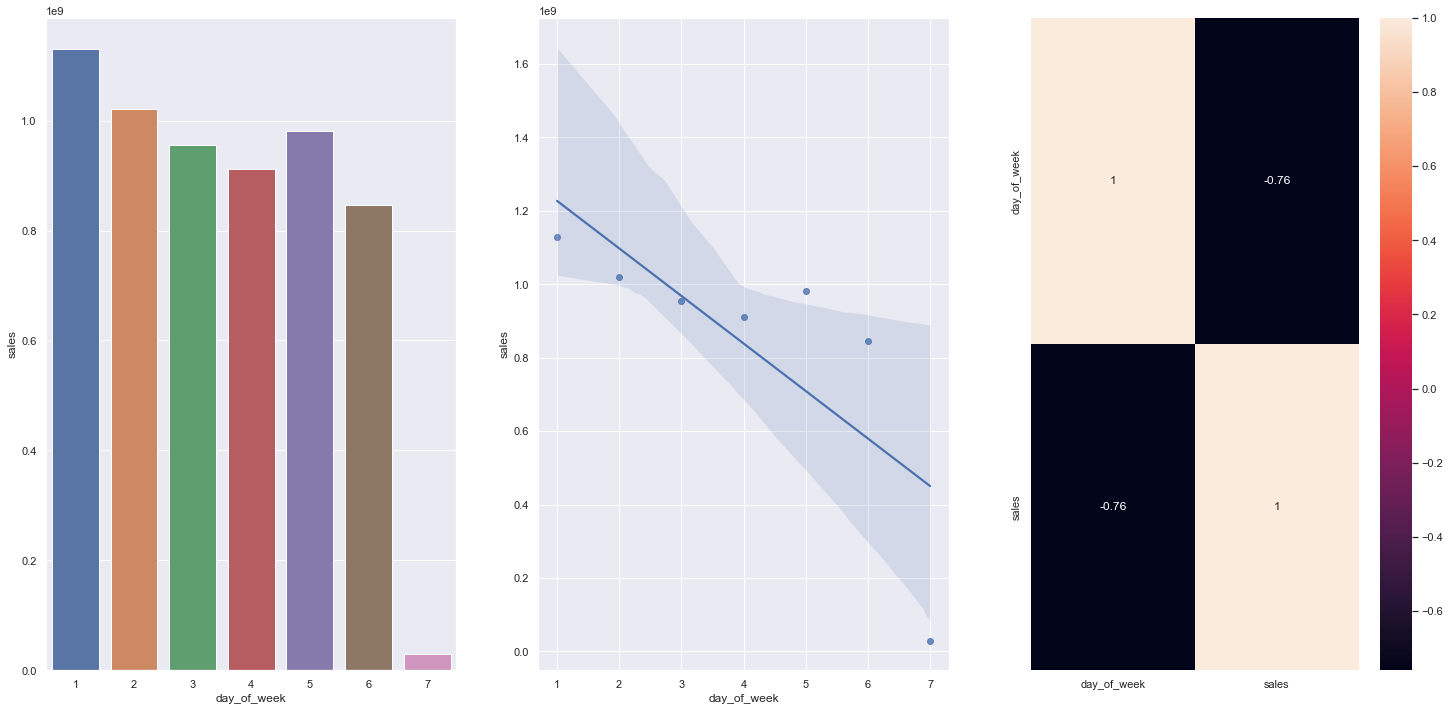

In [43]:
aux1 = df4[['sales','day_of_week']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.12 -> Lojas deveriam vender menos durante os feriados escolares 
VERDADEIRA -> Lojas <span style="font-size:16px"><b>vendem menos</b> </span><span style="font-size:16px"><b>durante os feriados escolares, exceto julho e agosto</b></span>.

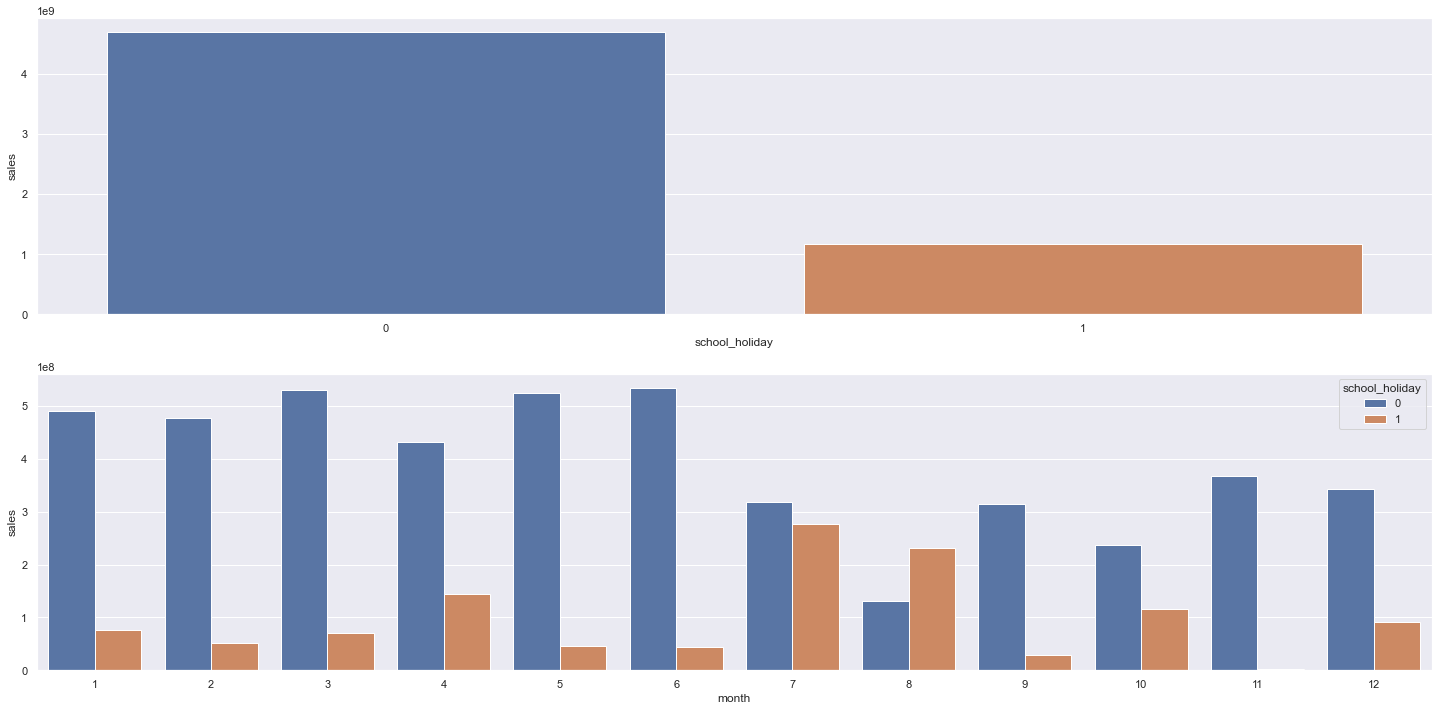

In [44]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### Resumo das hipóteses 

In [45]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

- O objetivo é retirar features que carregam a mesma quantidade de informação;

- Através da álgebra linear, podemos estabeler vetores codependentes entre as variáveis.

### 4.3.1 Atributos Numéricos

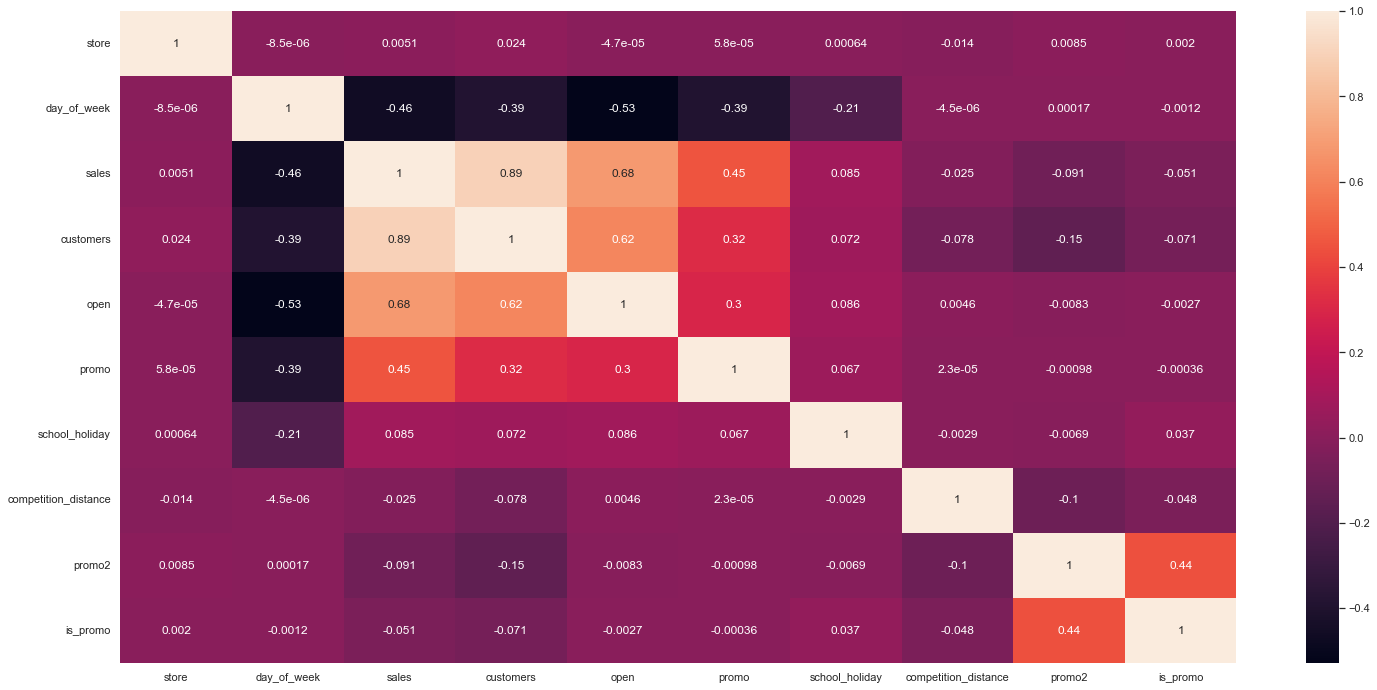

In [46]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos Categóricos

In [47]:
cat_attributes_update = df4.select_dtypes(include='object')
cat_attributes_update.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


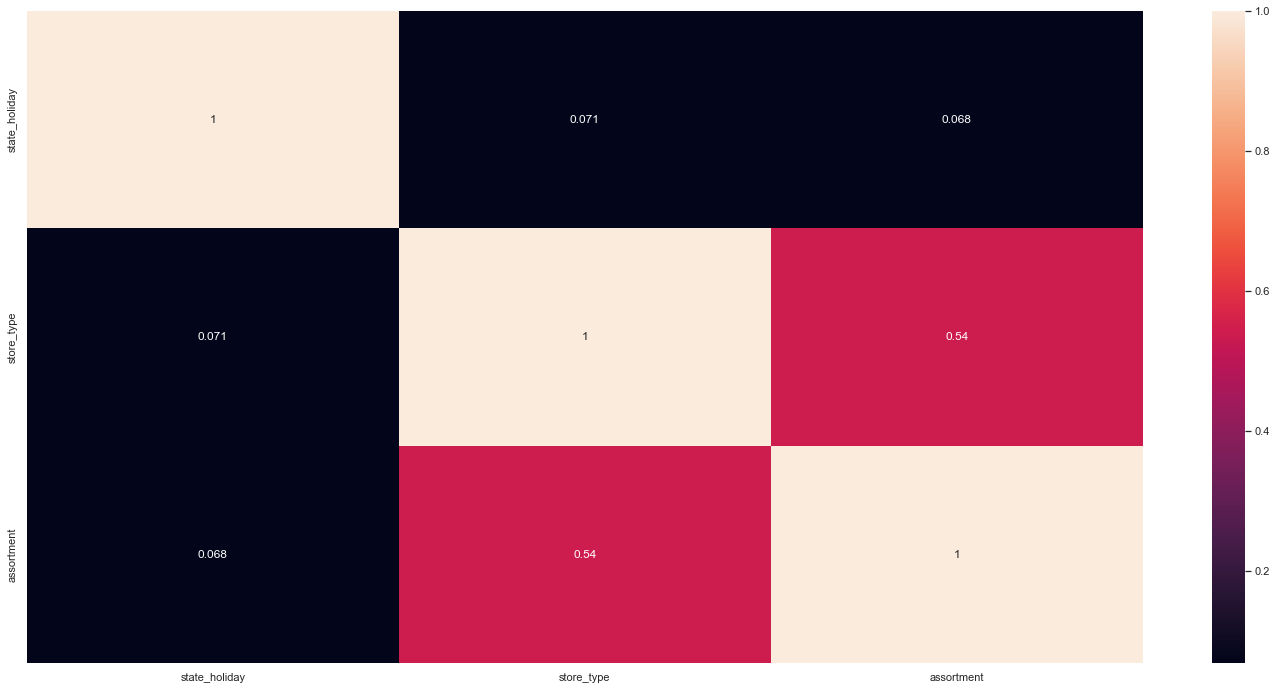

In [48]:
a1 = cramer_v(cat_attributes_update['state_holiday'], cat_attributes_update['state_holiday'])
a2 = cramer_v(cat_attributes_update['state_holiday'], cat_attributes_update['store_type'])
a3 = cramer_v(cat_attributes_update['state_holiday'], cat_attributes_update['assortment'])

a4 = cramer_v(cat_attributes_update['store_type'], cat_attributes_update['state_holiday'])
a5 = cramer_v(cat_attributes_update['store_type'], cat_attributes_update['store_type'])
a6 = cramer_v(cat_attributes_update['store_type'], cat_attributes_update['assortment'])

a7 = cramer_v(cat_attributes_update['assortment'], cat_attributes_update['state_holiday'])
a8 = cramer_v(cat_attributes_update['assortment'], cat_attributes_update['store_type'])
a9 = cramer_v(cat_attributes_update['assortment'], cat_attributes_update['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                  'store_type': [a4,a5,a6],
                  'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# Módulo 05 - Preparação dos Dados

## 5.0 Data Preparation

**Normalização:** rescala o centro para 0 e o desvio-padrão igual a 1; funciona bem para distribuições Gaussianas;
   
X_novo = (Xi - Xmédia) / desvio-padrão

**Rescaling:** rescala para o intervalo entre 0 e 1; funciona muito bem para distribuições não Gaussianas;

**Transformação:** conversão de features categóricas p/ numéricas (*ENCODING*); transformação de natureza.

In [49]:
df5 = df4.copy()

## 5.1 Normalização
Em 4.1.2, podemos observar a distribuição de nossas variáveis numéricas. <br>
Desta forma, não encontramos nenhuma distribuição que seja normal a uma distribuição normal.<br>
Portanto, não iremos normalizar nenhum dos dados.

## 5.2 Rescaling 

Min-Max Scaler: Xnovo = (X - média) / (Xmax - Xmin) # muito sensível para outliers

Robust Scaler: Xnovo = (X - Q1) / (Q3 - Q1)

In [50]:
df_rescaling = df5.select_dtypes(include=['int64', 'float64'])
df_rescaling.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day
0,1,5,5263,1,1,1270.0,0,0,2015,7,31
1,2,5,6064,1,1,570.0,1,0,2015,7,31
2,3,5,8314,1,1,14130.0,1,0,2015,7,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31


In [51]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

**Alguns tipos:**
1. One Hot Encoding: matriz de 0 e 1 para cada variável; aumenta bastante a dimensionalidade do modelo;<br>
<br>
2. Label Encoding: torna os dados categóricos em sequência numérica (1, 2, 3,..., n) sem ranquear;<br>
<br>
3. Ordinal Encoding: ranqueia os dados categóricos (ideia de ordem);<br>
<br>
4. Target Encoding: funciona quando o número de variáveis é muito grande; classifica em frações (0.1, 0.3, 0.7, por exemplo);<br>
<br>
5. Frequency Encoding: fraciona baseado no número de vezes que aparece;<br>
<br>
6. Embedding Encoding: embutido em redes neurais; muito usado em NLP.<br>

### 5.3.1 Endoding 

In [52]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dic = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dic )

### 5.3.2 Transformação - Variável Resposta

Grandeza -> tornar a váriavel resposta com uma distribuição normal (algoritmos de ML trabalham com essas distribuições);

Natureza -> 

**Tipos de transformação:**
1. Logaritmica 
2. Box-Cox
3. Raiz cúbica
4. Raiz quadrada
5. Seno e Cosseno

In [53]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de natureza 

In [54]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * 2. * np.pi/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * 2. * np.pi/7))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * 2. * np.pi/12))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * 2. * np.pi/12))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * 2. * np.pi/30))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * 2. * np.pi/30))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * 2. * np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * 2. * np.pi/52))

# Módulo 06 - Seleção de Atributos

"A explicação mais simples sobre um fenômeno observado, deveria prevalecer sobre explicações mais complexas." 

Occam's Razor

**Removendo variáveis colineares:** p. ex.: Modelo p/ descrever um carro: 4 rodas + 4 pneus; lanternas + faróis -> significam basicamente a mesma coisa, portanto, uma delas pode ser excluída;

**Tipos de seleção de atributos:**
1. Seleção univariada: escolher atributos pela RELEVÂNCIA em explicar a resposta -> COEFICIENTE DE CORRELAÇÃO;
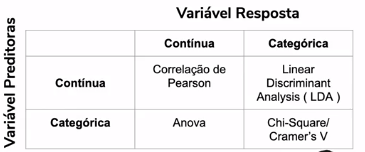
- Vantagens: método simples, rápido e de fácil entendimento;
- Desvantagens: não considera a influência entre as variáveis.

2. Seleção por importância: é um método embutido em alguns algoritmos -> p. ex.: Random Forest -> ele mesmo seleciona e "corta" features p/ construir a árvore com melhor resultado; *Gini Impurity:* a ideia é encontrar variáveis que dividam os dados em subgrupos homogêneos, até estabelecer as variáveis em ordem de importância; Outros algoritmos: Lasso Regression; Ridge Regression.


3. Seleção por subset (*wrapper method*): selecionar uma única variável e treinar um modelo de ML, em seguida, calcular a performance do modelo; adicionar uma nova variável e retreinar o modelo para reavaliar a performance comparar com o baseline; se a performance aumentou, manter a variável e adiciona outra variável para reavaliar a performance do modelo/ se a performance diminuiu, removemos a variável, adicionamos outra e repetimos o ciclo -> Algoritmo Boruta.

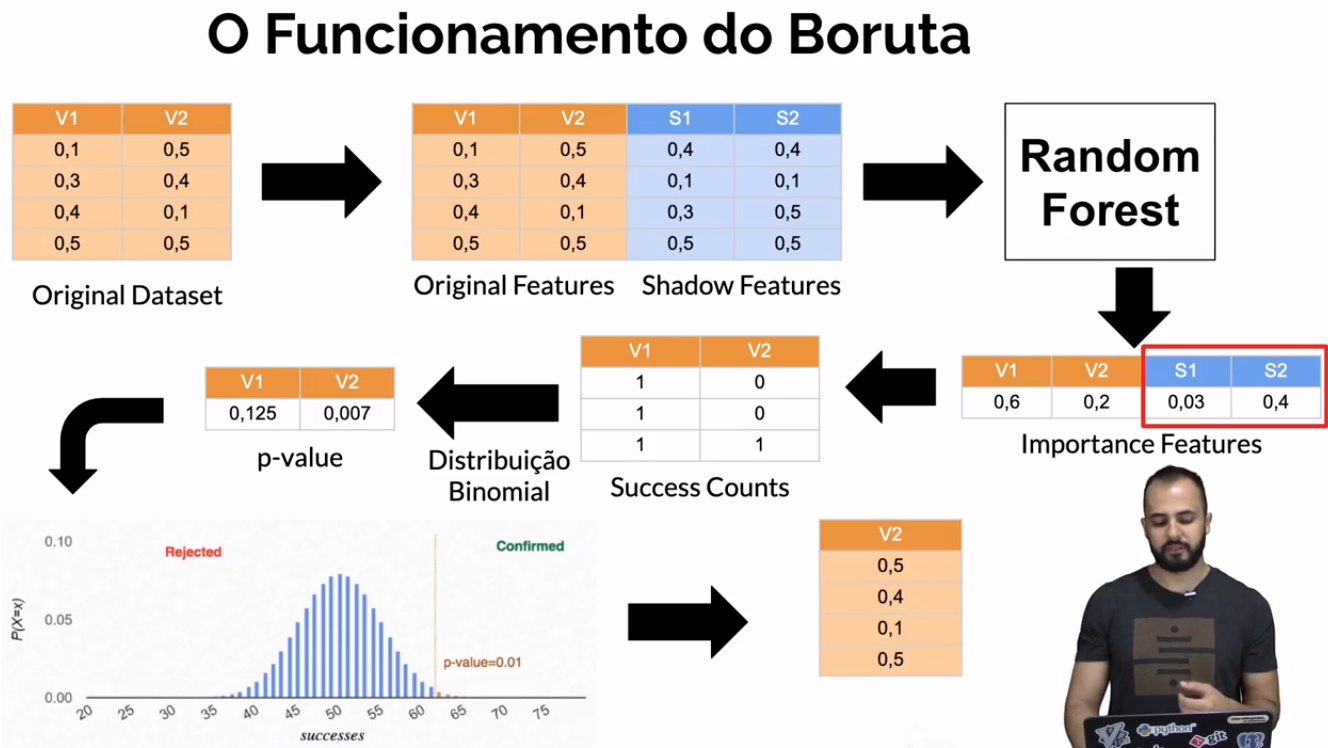

In [55]:
df6 = df5.copy()

In [56]:
# precisamos excluir as variáveis que foram derivadas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 
             'promo_since', 'competition_since', 'year_week']

df6.drop(cols_drop, axis=1, inplace=True)

## 6.1 Dividir dataset de treino e teste

Vamos selecionar as últimas seis semanas para teste e as outras para treino

In [57]:
# data miníma de cada uma das vendas das lojas
# df6[['store', 'date']].groupby('store').min().reset_index()

In [58]:
# data máxima de cada uma das vendas das lojas
# df6[['store', 'date']].groupby('store').max().reset_index()

In [59]:
# primeira data antes das últimas seis semanas
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [60]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.1.1 Salvando dados com pickle 

In [61]:
#with open('rossmann.pkl', mode = 'wb') as f:
  #pickle.dump([X_train, y_train, X_test, y_test], f)

### 6.1.2 Carregando dados com pickle

In [62]:
#with open('rossmann.pkl', 'rb') as f:
  #X_train, y_train, X_test, y_test = pickle.load(f)

## 6.2 Boruta as Feature Selector

In [63]:
# define training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# define Random Forest Regressor||
# rf = RandomForestRegressor(n_jobs=None)

In [64]:
# define Boruta 
# boruta = BorutaPy( rf, n_estimators=100, verbose=2, random_state=37 ).fit( X_train_n, y_train_n)

### 6.2.1 Melhores features - Boruta 

In [65]:
# cols_selected = boruta.support_.tolist()

## best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [66]:
# cols_selected_boruta

In [67]:
# cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [68]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos', 
 'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta + feat_to_add

# Módulo 07 - Modelos de Machine Learning
- Modelo de média
- Regressão linear
- Regressão linear regularizada
- Random Forest Regressor
- XGBoost Regressor

In [69]:
x_train = X_train[cols_selected_boruta] # sem 'date' e sem 'sales'
x_test = X_test[cols_selected_boruta]

# time series data preparation
x_training = X_train[cols_selected_boruta_full]

##  7.1 Modelo de média

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2          = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1          = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Regressão linear

In [71]:
# modelo
# lr = LinearRegression().fit(x_train, y_train)

# prediction
# yhat_lr = lr.predict(x_test)

# performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

### 7.2.1 Linear Regression - Cross Validation

In [72]:
# lr_result_cv = cross_validation(x_training, 5, "Linear Regression", lr, verbose=True)

## 7.3 Regressão linear regularizada (Lasso)

In [73]:
# modelo
# lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
# yhat_lrr = lrr.predict(x_test)

# performance
# lrr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1 Lasso - Cross Validation

In [74]:
# lrr_result_cv = cross_validation(x_training, 5, "Lasso", lrr, verbose=True)

## 7.4 Random Forest Regressor

In [75]:
# model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=12).fit(x_train, y_train)

# prediction
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [76]:
# rf_result_cv = cross_validation(x_training, 5, "Random Forest Regressor", rf, verbose=True)

## 7.5 XGBoost Regressor 

In [77]:
# model
# model_xgb = xgb.XGBRegressor(
#     objective = 'reg:squarederror',
#     n_estimators=100, 
#     eta=0.01,
#     max_depth=10,
#     subsample=0.7,
#     colsample_bytree=0.9).fit(x_train, y_train)

# # prediction
# yhat_xgb = model_xgb.predict(x_test)

# # performance
# xgb_result = ml_error("XGB", np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [78]:
# xgb_result_cv = cross_validation(x_training, 5, "XGBoost Regressor", model_xgb, verbose=True)

## 7.6 Compare Model's Performance 

### 7.6.1 Single Performance 

In [79]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [80]:
# modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modelling_result_cv.sort_values('RMSE')

# Módulo 08 - Fine Tunning 

Técnicas de Fine Tunning:
- Random Search: define valores aleatórios para cada um dos hiperparâmetros
    - Vantagens: é rápido e fácil de implementar; Desvantagens: pode selecionar os mesmos valores já testados em outras interações (perde tempo); encontra minímos locais apenas;
- Grid Search: define todas as combinações possíveis de valores que os hiperparâmetros podem assumir;
    - Vantagens: busca todas as combinações possíveis; Desvantagens: demanda muito tempo;
- Bayesian Search: define os valores de hiperparâmetros seguindo a teoria de Bayes
    - Trabalha com a probabilidade do efeito de cada mudança nos valores de hiperparâmetro (meio termo entre Random e Grid).

## 8.1 Random Search 

In [81]:
# param = {
#     'n_estimators':[1500, 1700, 2500, 3000, 3500],
#     'eta':[0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample':[0.1, 0.5, 0.7],
#     'colsample_bytree':[0.3, 0.7, 0.9],
#     'min_child_weight':[3, 8, 15]
# }

# MAX_EVAL = 10

In [82]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
    # choose values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)
    
    # model
#     model_xgb = xgb.XGBRegressor(
#         objective = 'reg:squarederror',
#         n_estimators=hp['n_estimators'], 
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight'])

    # performance
#     result = cross_validation(x_training, 5, "XGBoost Regressor", model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])
    
# final_result

In [83]:
# param_tuned = {
#     'n_estimators':3000,
#     'eta':0.3,
#     'max_depth': 5,
#     'subsample':0.7,
#     'colsample_bytree':0.7,
#     'min_child_weight':3
# }

In [84]:
# # model
# model_xgb_tuned = xgb.XGBRegressor(
#     objective = 'reg:squarederror',
#     n_estimators=param_tuned['n_estimators'], 
#     eta=param_tuned['eta'],
#     max_depth=param_tuned['max_depth'],
#     subsample=param_tuned['subsample'],
#     colsample_bytree=param_tuned['colsample_bytree']).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# # performance
# xgb_result_tuned = ml_error("XGB", np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGB,654.066441,0.096591,944.761148


In [93]:
# saving model and predictions

# pickle.dump( model_xgb_tuned, open("C:/Users/User/Documents/repos/rossman_sales_prediction/Rossman-Sales-Prediction-master/model_rossmann.pkl", 'wb'))
# pickle.dump( yhat_xgb_tuned, open("C:/Users/User/Documents/repos/rossman_sales_prediction/Rossman-Sales-Prediction-master/yhat_xgb_tuned.pkl", 'wb'))

# Módulo 09 - Tradução do Erro

In [99]:
# loading model and predictions
with open('model_rossmann.pkl', 'rb') as f:  
    model_xgb_tuned = pickle.load(f)

with open('yhat_xgb_tuned.pkl', 'rb') as f:  
    yhat_xgb_tuned = pickle.load(f)

## 9.1 Business Performance

In [104]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

df9.head(3)

C:\Users\User\AppData\Local\Temp\ipykernel_15328\3340846733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\User\AppData\Local\Temp\ipykernel_15328\3340846733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,5263.0,5348.323242
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,6064.0,5499.827148
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,8314.0,9440.239258


In [123]:
# sum of predictions
df91 = df9[['store', 'sales', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df_aux1, df_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']].sort_values(by='MAPE', ascending=False)

In [136]:
df92.head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,137966.0,104372.460938,100996.778230,107748.143645,3375.682707,0.580496
908,909,360069.0,241643.828125,234034.973824,249252.682426,7608.854301,0.523992
875,876,257556.0,201518.000000,197679.747336,205356.252664,3838.252664,0.293480
721,722,279296.0,350215.875000,348299.122018,352132.627982,1916.752982,0.255858
273,274,253372.0,192166.484375,190743.100234,193589.868516,1423.384141,0.245766


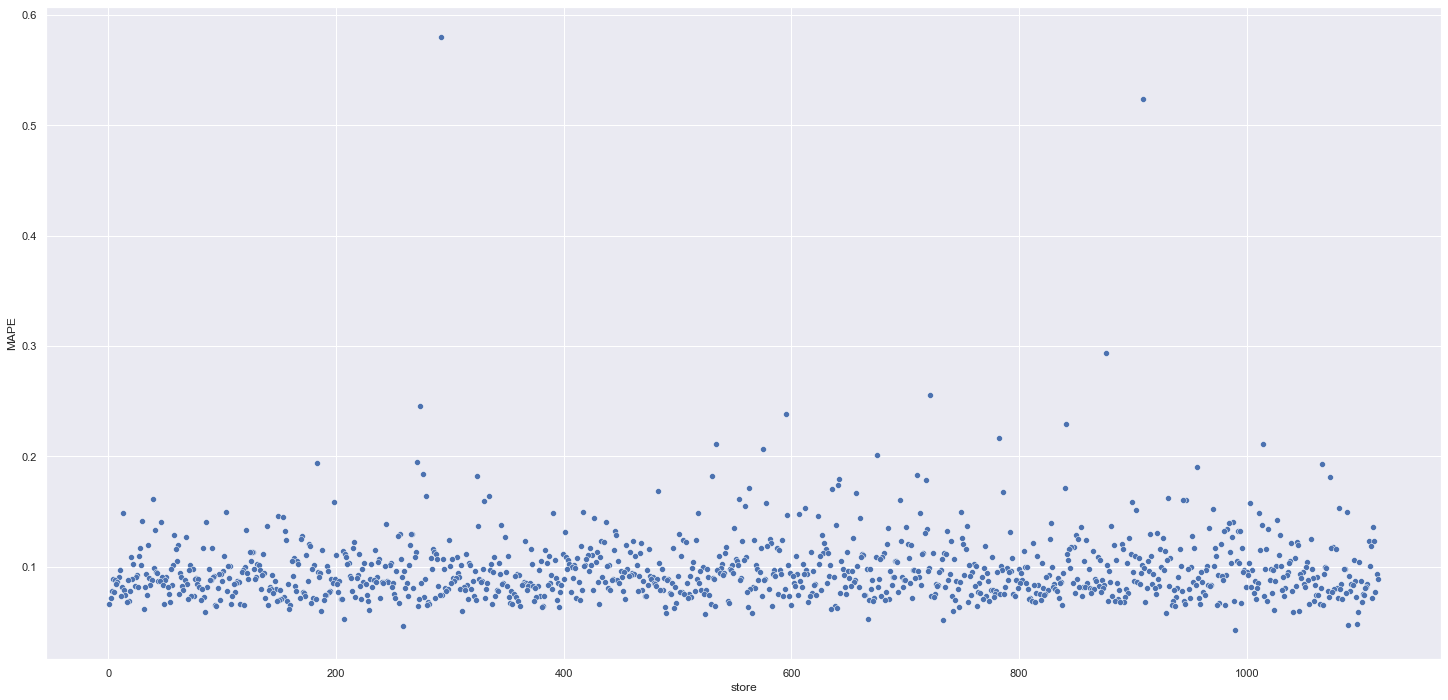

In [139]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [135]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$ 286,659,200.00"
1,worst_scenario,"R$ 285,925,935.18"
2,best_scenario,"R$ 287,392,487.69"


## 9.3 Machine Learning Performance

C:\Users\User\AppData\Local\Temp\ipykernel_15328\3899131827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions'];
C:\Users\User\AppData\Local\Temp\ipykernel_15328\3899131827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales'];
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your 

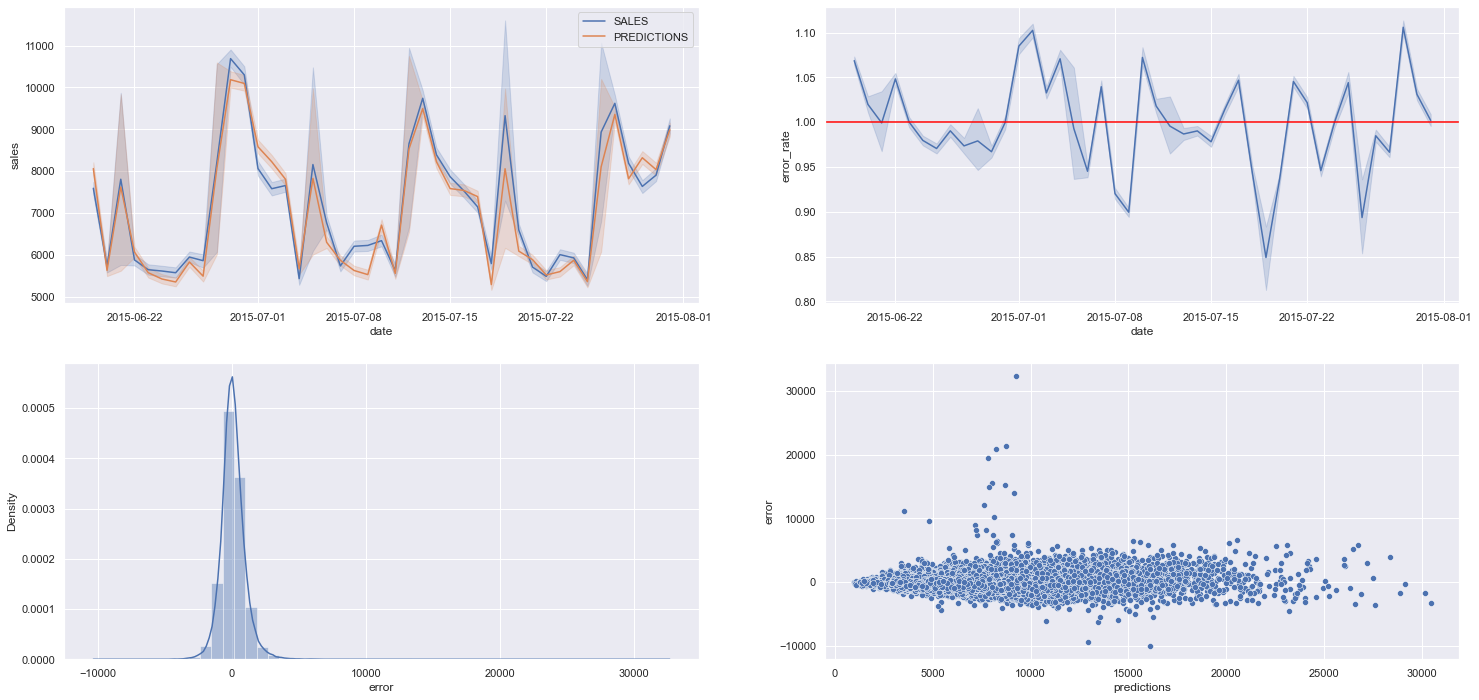

In [144]:
df9['error'] = df9['sales'] - df9['predictions'];
df9['error_rate'] = df9['predictions'] / df9['sales'];

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES') # sombreado é o plot de todas as vendas
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS') # sombreado é o plot de todas as predições

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='-', color='red')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df9);